In [1]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
from gc import collect

import numpy
import matplotlib.pyplot as plt
from h5py import File
from astropy.cosmology import FlatLambdaCDM
import csiborgtools

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
def get_particles_gadget(kind, fpath):
    with File(fpath, "r") as f:
        if kind == "Masses":
            npart = f["Header"].attrs["NumPart_Total"][1]
            x_high = numpy.ones(npart, dtype=numpy.float32)
            x_high *= f["Header"].attrs["MassTable"][1]
        else:
            x_high = f[f"PartType1/{kind}"][...]

        x_low = f[f"PartType5/{kind}"][...]

    return x_high, x_low

In [174]:
option = "csiborg2"
chain_index = 16017
distances = numpy.linspace(0, 155, 101)[1:]

if option == "csiborg1":
    if chain_index != 8600:
        raise ValueError(f"Invalid chain index: `{chain_index}`.")

    fpath_csiborg = "/mnt/extraspace/rstiskalek/csiborg1/gadget4/chain_8600/output/snapshot_099.hdf5"
    fpath_borg = f"/mnt/users/hdesmond/BORG_final/mcmc_{chain_index}.h5"
    Om0 = 0.307
    boxsize = 677.7
    H0 = 70.5
elif option == "csiborg2":
    fpath_csiborg = f"/mnt/extraspace/rstiskalek/csiborg2_main/chain_{chain_index}/output/snapshot_099_full.hdf5"
    fpath_borg = f"/mnt/extraspace/rstiskalek/BORG_STOPYRA_2023/mcmc_{chain_index}.h5"
    Om0 = 0.3111
    H0 = 67.66
    boxsize = 676.6
else:
    raise ValueError(f"Invalid option: `{option}`.")


rho_matter_borg = Om0 * FlatLambdaCDM(H0=H0, Om0=Om0).critical_density(0).to("Msun/Mpc^3").value
rho_matter = Om0 * FlatLambdaCDM(H0=100, Om0=Om0).critical_density(0).to("Msun/Mpc^3").value

In [175]:
print("Getting positions")
pos_high, pos_low = get_particles_gadget("Coordinates", fpath_csiborg)
print("Getting masses")
mass_high, mass_low = get_particles_gadget("Masses", fpath_csiborg)

print("Concatenating the high- and low-resolution particles.")
pos = numpy.concatenate([pos_high, pos_low])
mass = numpy.concatenate([mass_high, mass_low]) * 1e10

del pos_high, pos_low, mass_high, mass_low
collect()

print("Calculating the radial distances.")
pos -= boxsize / 2
rdist = numpy.linalg.norm(pos, axis=1)

del pos
collect()

print("Sorting particles")
indxs = numpy.argsort(rdist)
rdist = rdist[indxs]
mass = mass[indxs]

Getting positions
Getting masses
Concatenating the high- and low-resolution particles.
Calculating the radial distances.
Sorting particles


In [193]:
# print("Calculating the enclosed mass in CSiBORG.")
# csiborg_mass = csiborgtools.field.particles_enclosed_mass(rdist, mass, distances)
# volume = 4 / 3 * numpy.pi * distances**3
# csiborg_overdensity = csiborg_mass / volume / rho_matter - 1


print("Calculating the enclosed mass in BORG.")
with File(fpath_borg) as f:
    borg_density = f["scalars/BORG_final_density"][...].T
    borg_density += 1
    borg_density *= rho_matter_borg

h = H0 / 100

# Now BORG_density is the density in each cell in units of borg H0.
borg_mass, borg_volume = csiborgtools.field.field_enclosed_mass(
    borg_density, distances, boxsize)

# Now we need to conver the mass to units of h = 1
borg_density = borg_mass / borg_volume
borg_overdensity = borg_density / rho_matter_borg - 1

Calculating the enclosed mass in BORG.


/tmp/ipykernel_2000/2304497414.py:20: RuntimeWarning: invalid value encountered in divide
  borg_density = borg_mass / borg_volume


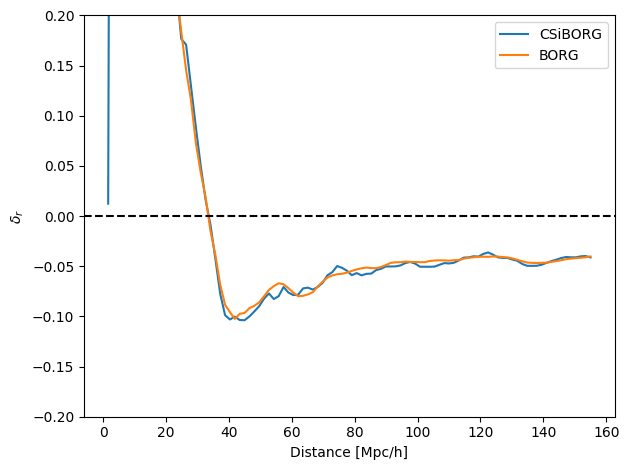

In [195]:
plt.figure()

plt.plot(distances, csiborg_overdensity, label="CSiBORG")
plt.plot(distances, borg_overdensity * 0.7, label="BORG")

# plt.plot(distances, borg_overdensity - csiborg_overdensity)
plt.axhline(0, color="black", linestyle="--")

# plt.ylim(0.7, 1.3)
plt.ylim(-0.2, 0.2)
plt.ylabel(r"$\delta_r$")
plt.xlabel("Distance [Mpc/h]")

plt.legend()
plt.tight_layout()
# plt.savefig("/mnt/users/rstiskalek/csiborgtools/plots/enclosed_overdensity_8600.png", dpi=300)
plt.show()

In [61]:
csiborg_reader = csiborgtools.read.CSiBORG2Field(17417, "main")
borg_reader = csiborgtools.read.BORG2Field(17417)
Om0 = 0.3111
boxsize = 676.6

# csiborg_reader = csiborgtools.read.CSiBORG1Field(9844)
# borg_reader = csiborgtools.read.BORG1Field(9844)
# Om0 = 0.307
# boxsize = 677.7

cosmo = FlatLambdaCDM(H0=100, Om0=Om0)
rho_matter = Om0 * cosmo.critical_density(0).to("Msun/kpc^3").value

In [62]:
csiborg_density = csiborg_reader.density_field("SPH", 1024)


csiborg_density /= rho_matter
csiborg_density -= 1

borg_overdensity = borg_reader.overdensity_field()

In [63]:
csiborg_density_downsample = csiborg_density.reshape(256, 4, 256, 4, 256, 4).mean(axis=(1, 3, 5))


In [64]:
y_csiborg = []
y_borg = []

dks = range(0, 128 + 1)
for dk in dks:
    kmin = 128 - dk
    kmax = 128 + dk

    y_csiborg.append(numpy.mean(csiborg_density_downsample[kmin:kmax, kmin:kmax, kmin:kmax]))
    y_borg.append(numpy.mean(borg_overdensity[kmin:kmax, kmin:kmax, kmin:kmax]))

y_csiborg = numpy.array(y_csiborg)
y_borg = numpy.array(y_borg)

/mnt/users/rstiskalek/csiborgtools/venv_csiborg/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/users/rstiskalek/csiborgtools/venv_csiborg/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


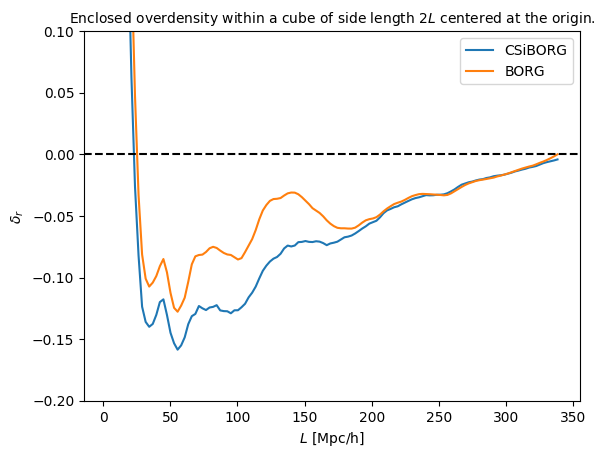

In [66]:
dks_phys = numpy.array(dks) * (boxsize / 256)

plt.figure()
plt.title("Enclosed overdensity within a cube of side length $2 L$ centered at the origin.", fontsize=10)
plt.plot(dks_phys, y_csiborg, label="CSiBORG")
plt.plot(dks_phys, y_borg, label="BORG")
plt.xlabel(r"$L ~ [\mathrm{Mpc}/\mathrm{h}]$")
plt.ylabel(r"$\delta_r$")
plt.axhline(0, color="black", linestyle="--")
plt.legend()
plt.ylim(-0.2, 0.1)
plt.savefig("../plots/BORG_enclosed_gadget2.png", dpi=300)
plt.show()

array([  0.        ,   2.64296875,   5.2859375 ,   7.92890625,
        10.571875  ,  13.21484375,  15.8578125 ,  18.50078125,
        21.14375   ,  23.78671875,  26.4296875 ,  29.07265625,
        31.715625  ,  34.35859375,  37.0015625 ,  39.64453125,
        42.2875    ,  44.93046875,  47.5734375 ,  50.21640625,
        52.859375  ,  55.50234375,  58.1453125 ,  60.78828125,
        63.43125   ,  66.07421875,  68.7171875 ,  71.36015625,
        74.003125  ,  76.64609375,  79.2890625 ,  81.93203125,
        84.575     ,  87.21796875,  89.8609375 ,  92.50390625,
        95.146875  ,  97.78984375, 100.4328125 , 103.07578125,
       105.71875   , 108.36171875, 111.0046875 , 113.64765625,
       116.290625  , 118.93359375, 121.5765625 , 124.21953125,
       126.8625    , 129.50546875, 132.1484375 , 134.79140625,
       137.434375  , 140.07734375, 142.7203125 , 145.36328125,
       148.00625   , 150.64921875, 153.2921875 , 155.93515625,
       158.578125  , 161.22109375, 163.8640625 , 166.50

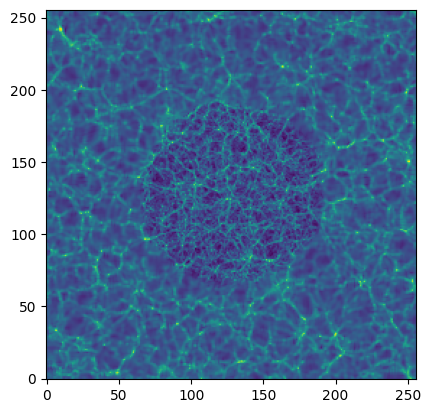

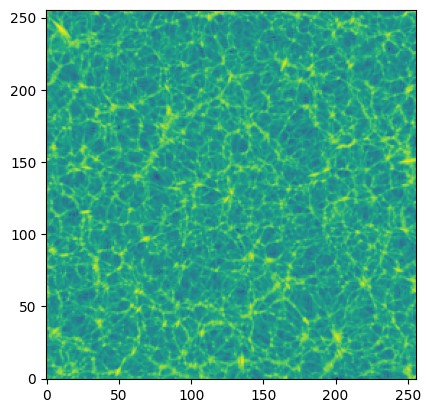

In [213]:
plt.figure()
plt.imshow(numpy.log10(csiborg_density_downsample[:, :, 128]), origin="lower")
plt.show()


plt.figure()
plt.imshow(numpy.log10(borg_overdensity[:, :, 128] + 1), origin="lower")
plt.show()